In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from scipy.stats import beta, bernoulli
import numpy as np

In [2]:
def dummy_genrator(conversion_rate, n_impression):
    return np.array(bernoulli(conversion_rate).rvs(n_impression))

In [3]:
a = dummy_genrator(0.015, 204)
b = dummy_genrator(0.021, 200)
imp_a = len(a)
imp_b = len(b)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))

A 
表示数: 204
購入数: 2

B 
表示数: 200
購入数: 5



In [54]:
class BayesianAB:
    
    def __init__(self, params=None, size=2):
        """
            params are a list of Beta distribution's initial params. e.g. [[alpha of A, beta of A], [alpha of B, beta of B]]
        """
        if params is None:
            self.params = []
            for _ in range(size):
                self.params.append([1,1])
        self.size = len(self.params)
        self.data = []
        for _ in range(size):
            self.data.append([0,0])
        print("the number of comparison: ", self.size)
        self.sampling()
        
    def update(self, data, sampling=True):
        """
         data are a list of pairs of impression and conversion. e.g. [[imp of A, conv of A], [imp of B, conv of B]]
        """
        if self.size != len(data):
            print("No match of the size.")
        
        for p, current, new in zip(self.params, self.data, data):
            imp = new[0]
            conv = new[1]
            current[0] += imp
            current[1] += conv
            p[0] += conv
            p[1] += (imp - conv)
        if sampling:
            self.sampling()
        
        
    def mean_ver(self):
        """
            return [(mean of A, variance of A), (mean of B, variance of B), ...]
        """
        return  [(posterior.mean(), posterior.var())for posterior in self.posterior_list]

        
        
    def sampling(self, n_samples=30000):
        print("num of samples: ", n_samples)
        self.posterior_list = [beta(*p).rvs(n_samples) for p in self.params]


        
    def show_beta(self, title="", save=False, labels=None):
        
        plt.figure(figsize=(10, 5))
        plt.title("Posterior distribution "+ title)
        
        cmap = plt.get_cmap('jet')
        color_list= []
            
        for i, posterior in enumerate(self.posterior_list):
            color =cmap(0.25*(i+1))
            color_list.append(color)
            plt.hist(posterior, bins=100, histtype="stepfilled", normed=True, color=color, alpha=0.5)
        handles = [Rectangle((0,0),1,1,color=c, ec="k", alpha=0.5) for c in color_list]
        
        if labels is None:
            labels = [chr(65+i) for i in range(self.size)] # create A,B,...
            

        plt.legend(handles, labels)
        if save:
            plt.savefig("{}.png".format(title))
        plt.show()
    
    def diff_prob(self, index_high, index_low):
        prob = (self.posterior_list[index_low] < self.posterior_list[index_high]).mean()
        if prob < 0.5:
            prob = 1 - prob
        return prob
    
    def show_metrics(self):
        print(self.data)
        
    def metrics(self, labels=None):
        if labels is None:
            labels = [chr(65+i) for i in range(self.size)] # create A,B,...
        return pd.DataFrame(self.data, index=labels, columns=["Impressions", "Conversions"])
        

In [55]:
abtest = BayesianAB()

the number of comparison:  2
num of samples:  30000


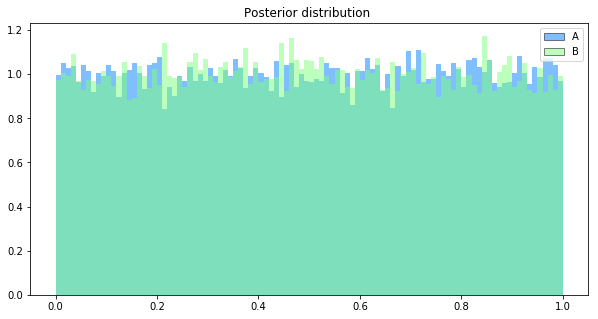

In [56]:
abtest.show_beta()

In [57]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b]])

num of samples:  30000


In [58]:
abtest.mean_ver()

[(0.015346559982177547, 5.930037696150928e-08),
 (0.020925755071378768, 9.320852168415905e-08)]

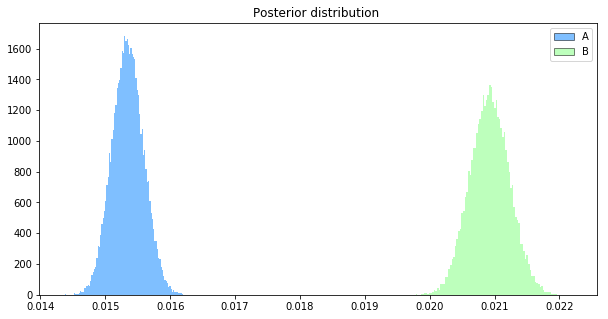

In [59]:
abtest.show_beta()

In [60]:
abtest.diff_prob(0,1)

1.0

In [61]:
abtest.show_metrics()

[[251000, 3851], [220000, 4603]]


In [62]:
a = dummy_genrator(0.015, 20400)
b = dummy_genrator(0.021, 20000)
imp_a = len(a)
imp_b = len(b)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))

A 
表示数: 20400
購入数: 276

B 
表示数: 20000
購入数: 419



In [63]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b]])

num of samples:  30000


In [64]:
abtest.show_metrics()

[[271400, 4127], [240000, 5022]]


In [65]:
abtest.metrics()

,Impressions,Conversions
A,271400,4127
B,240000,5022


In [66]:
a = dummy_genrator(0.015, 2510)
b = dummy_genrator(0.021, 2000)
c = dummy_genrator(0.016, 2330)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("B \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 2510
購入数: 39

B 
表示数: 2000
購入数: 44

B 
表示数: 2330
購入数: 34



the number of comparison:  3
num of samples:  30000
num of samples:  30000


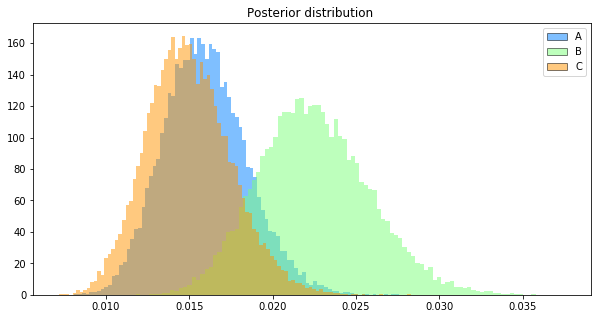

In [67]:
abtest = BayesianAB(size=3)
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
#abtest.diff_prob()

In [68]:
abtest.metrics()

,Impressions,Conversions
A,2510,39
B,2000,44
C,2330,34


In [69]:
abtest.diff_prob(1,0)

0.9455

In [70]:
abtest.diff_prob(1,2)

0.9673333333333334

In [71]:
abtest.diff_prob(2,0)

0.6089333333333333

In [72]:
a = dummy_genrator(0.015, 25100)
b = dummy_genrator(0.021, 22000)
c = dummy_genrator(0.016, 23300)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("B \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 25100
購入数: 370

B 
表示数: 22000
購入数: 447

B 
表示数: 23300
購入数: 394



num of samples:  30000


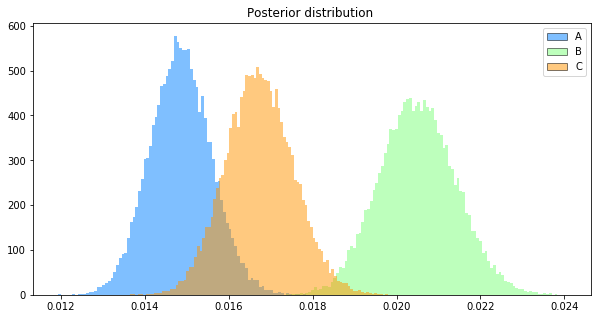

[(0.014848077086459351, 5.302755461354647e-07),
 (0.020499801676327353, 8.304548309774921e-07),
 (0.016736877713460555, 6.48543987556852e-07)]

In [73]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
abtest.mean_ver()

In [74]:
abtest.metrics()

,Impressions,Conversions
A,27610,409
B,24000,491
C,25630,428


In [75]:
abtest.diff_prob(1,0)

1.0

In [76]:
abtest.diff_prob(1,2)

0.9990333333333333

In [77]:
abtest.diff_prob(0,2)

0.9597666666666667

In [78]:
a = dummy_genrator(0.015, 251000)
b = dummy_genrator(0.021, 220000)
c = dummy_genrator(0.016, 233000)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("B \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 251000
購入数: 3704

B 
表示数: 220000
購入数: 4643

B 
表示数: 233000
購入数: 3782



num of samples:  30000


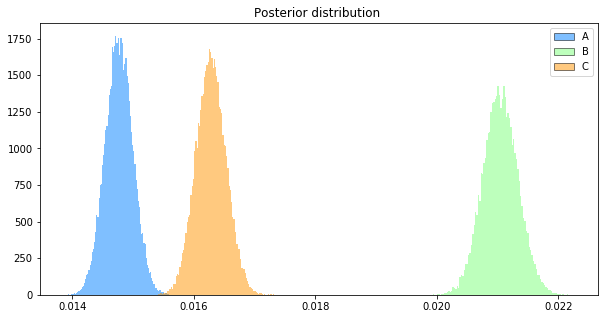

[(0.014766924466303408, 5.235800379319372e-08),
 (0.021043674741217346, 8.392625953390993e-08),
 (0.0162819369277526, 6.175138482479748e-08)]

In [79]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
abtest.mean_ver()

In [80]:
abtest.diff_prob(2,0)

1.0